# Main Modelling Notebook

In [71]:
import itertools as it
import matplotlib
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import pandas as pd
import re
import scipy as sp
import sklearn.preprocessing as Preprocessing
import datetime

from itertools import combinations
from sklearn.cross_validation import KFold as kfold
from sklearn.decomposition import TruncatedSVD as tSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import LogisticRegression as Log_Reg
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier as DTC
from scipy.io import mmread

%matplotlib inline
plt.style.use('ggplot') 
from IPython.display import display, HTML

#### Load Data

In [72]:
# load data
%run -i data_loading.py

248445
113036
Indexes computed

address_state object
annual_income float64
cpi float64
delinq_2_yrs int64
desc_len float64
dti float64
employ_length object
employ_title object
gdp float64
home_owner object
initial_list_status object
inquiry_6_mos int64
installment float64
ipr float64
loan_amount int64
loan_purpose object
loan_term int64
months_since_last_record float64
open_accounts int64
revol_util float64
rir float64
total_accounts int64
unemploy float64
months_since_earliest_credit float64
(Training set has 28182 rows)

address_state object
annual_income float64
cpi float64
delinq_2_yrs int64
desc_len float64
dti float64
employ_length object
employ_title object
gdp float64
home_owner object
initial_list_status object
inquiry_6_mos int64
installment float64
ipr float64
loan_amount int64
loan_purpose object
loan_term int64
months_since_last_record float64
open_accounts int64
revol_util float64
rir float64
total_accounts int64
unemploy float64
months_since_earliest_credit float64
(Test

#### Set up Modelling Framework

In [73]:
# set up modelling framework
% run -i modelling_framework.py

#### Models without PCA

In [74]:
y.value_counts()

True     23897
False     4285
Name: loan_status, dtype: int64

In [75]:
y.mean()

0.84795259385423316

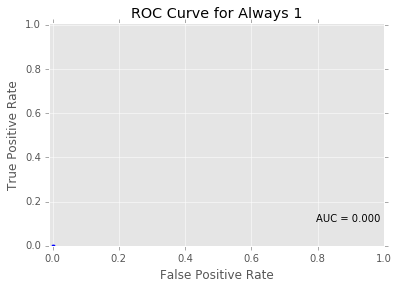

all   score: 0.152  baseline: 0.848   prec: 0.848   f1: 0.000  | test score 0.848  prec 0.848 f1 0.918  GP 1221MM
2011  score: 0.104  baseline: 0.896   prec: 0.896   f1: 0.000  | test score 0.107  prec 0.893
2012  score: 0.134  baseline: 0.866   prec: 0.866   f1: 0.000  | test score 0.135  prec 0.865
2013  score: 0.178  baseline: 0.822   prec: 0.822   f1: 0.000  | test score 0.176  prec 0.824


In [76]:
eval_model_by_year(lambda: DummyClassifier(strategy='constant', constant=0), model_name='Always 1')

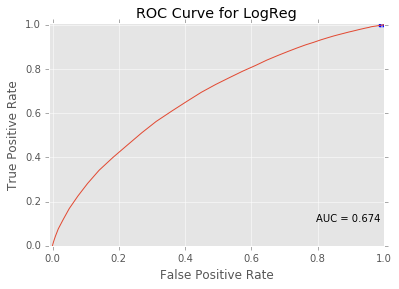

all   score: 0.848  baseline: 0.848   prec: 0.540   f1: 0.917  | test score 0.152  prec 0.540 f1 0.005  GP -901MM
2011  score: 0.895  baseline: 0.896   prec: 0.550   f1: 0.944  | test score 0.893  prec 0.600
2012  score: 0.866  baseline: 0.866   prec: 0.533   f1: 0.928  | test score 0.865  prec 0.711
2013  score: 0.821  baseline: 0.822   prec: 0.521   f1: 0.901  | test score 0.823  prec 0.522


In [77]:
eval_model_by_year(lambda: Log_Reg(), model_name='LogReg')

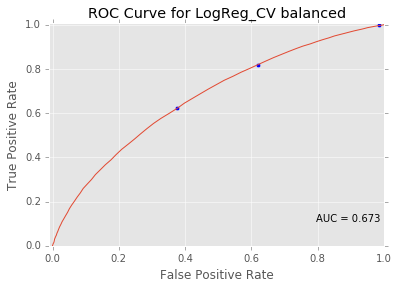

all   score: 0.629  baseline: 0.848   prec: 0.768   f1: 0.742  | test score 0.377  prec 0.772 f1 0.507  GP -33MM
2011  score: 0.635  baseline: 0.896   prec: 0.852   f1: 0.761  | test score 0.644  prec 0.840
2012  score: 0.614  baseline: 0.866   prec: 0.807   f1: 0.735  | test score 0.610  prec 0.813
2013  score: 0.638  baseline: 0.822   prec: 0.727   f1: 0.745  | test score 0.635  prec 0.733


In [78]:
eval_model_by_year(lambda: Log_Reg_CV(class_weight='balanced'), model_name='LogReg_CV balanced') # TODO: print C afterwards

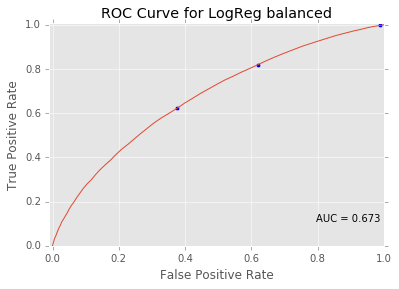

all   score: 0.629  baseline: 0.848   prec: 0.768   f1: 0.742  | test score 0.377  prec 0.772 f1 0.507  GP -33MM
2011  score: 0.636  baseline: 0.896   prec: 0.850   f1: 0.761  | test score 0.640  prec 0.840
2012  score: 0.614  baseline: 0.866   prec: 0.807   f1: 0.735  | test score 0.610  prec 0.813
2013  score: 0.636  baseline: 0.822   prec: 0.728   f1: 0.742  | test score 0.636  prec 0.733


In [79]:
eval_model_by_year(lambda: Log_Reg(class_weight='balanced'), model_name='LogReg balanced')

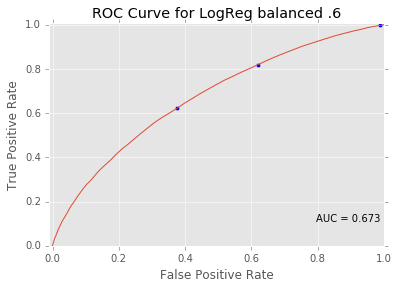

all   score: 0.629  baseline: 0.848   prec: 0.717   f1: 0.742  | test score 0.247  prec 0.726 f1 0.288  GP -437MM
2011  score: 0.636  baseline: 0.896   prec: 0.834   f1: 0.761  | test score 0.640  prec 0.817
2012  score: 0.614  baseline: 0.866   prec: 0.769   f1: 0.735  | test score 0.610  prec 0.790
2013  score: 0.636  baseline: 0.822   prec: 0.668   f1: 0.742  | test score 0.636  prec 0.684


In [80]:
eval_model_by_year(lambda: Log_Reg(class_weight='balanced'), prob_threshold=.6, model_name='LogReg balanced .6')

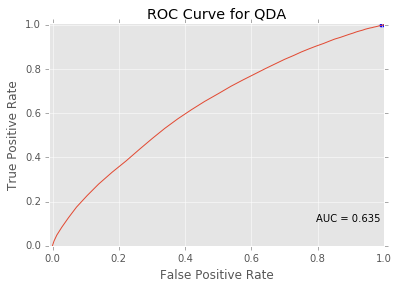

all   score: 0.847  baseline: 0.848   prec: 0.613   f1: 0.917  | test score 0.153  prec 0.628 f1 0.006  GP -903MM
2011  score: 0.890  baseline: 0.896   prec: 0.765   f1: 0.941  | test score 0.890  prec 0.703
2012  score: 0.865  baseline: 0.866   prec: nan   f1: 0.928  | test score 0.865  prec 0.596
2013  score: 0.818  baseline: 0.822   prec: 0.582   f1: 0.899  | test score 0.818  prec 0.638


In [81]:
eval_model_by_year(lambda: QDA(reg_param = 1), model_name='QDA')

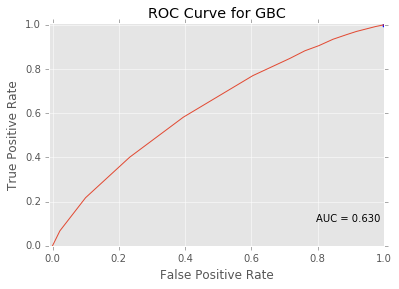

all   score: 0.848  baseline: 0.848   prec: nan   f1: 0.918  | test score 0.152  prec nan f1 0.000  GP -915MM
2011  score: 0.896  baseline: 0.896   prec: nan   f1: 0.945  | test score 0.893  prec 0.500
2012  score: 0.866  baseline: 0.866   prec: nan   f1: 0.928  | test score 0.865  prec nan
2013  score: 0.822  baseline: 0.822   prec: nan   f1: 0.902  | test score 0.824  prec nan


In [82]:
eval_model_by_year(lambda: GBC(n_estimators = 10, max_depth = 2, learning_rate = 0.1), model_name='GBC')

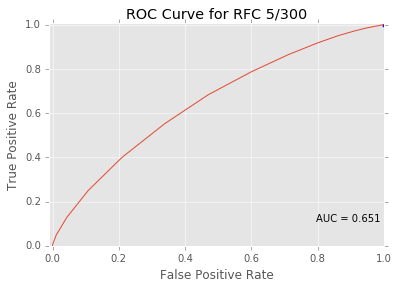

all   score: 0.848  baseline: 0.848   prec: nan   f1: 0.918  | test score 0.152  prec nan f1 0.000  GP -915MM
2011  score: 0.896  baseline: 0.896   prec: nan   f1: 0.945  | test score 0.893  prec nan
2012  score: 0.866  baseline: 0.866   prec: nan   f1: 0.928  | test score 0.865  prec nan
2013  score: 0.822  baseline: 0.822   prec: nan   f1: 0.902  | test score 0.824  prec nan


In [83]:
eval_model_by_year(lambda: RFC(random_state=1729, max_depth=5, n_estimators=300), model_name='RFC 5/300')

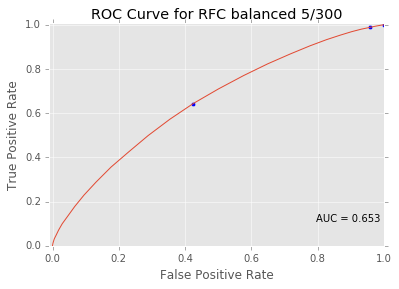

all   score: 0.634  baseline: 0.848   prec: 0.779   f1: 0.750  | test score 0.367  prec 0.776 f1 0.488  GP -76MM
2011  score: 0.739  baseline: 0.896   prec: 0.844   f1: 0.843  | test score 0.741  prec 0.824
2012  score: 0.635  baseline: 0.866   prec: 0.814   f1: 0.757  | test score 0.640  prec 0.816
2013  score: 0.646  baseline: 0.822   prec: 0.736   f1: 0.756  | test score 0.649  prec 0.737


In [84]:
eval_model_by_year(lambda: RFC(random_state=1729, max_depth=5, class_weight = 'balanced', n_estimators=300),
                   model_name='RFC balanced 5/300')

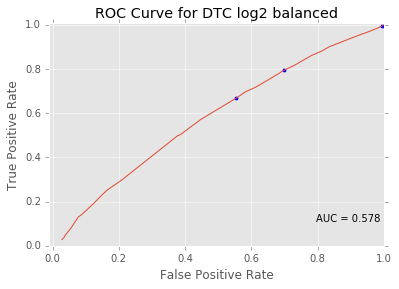

all   score: 0.568  baseline: 0.848   prec: 0.814   f1: 0.691  | test score 0.365  prec 0.806 f1 0.469  GP -159MM
2011  score: 0.531  baseline: 0.896   prec: 0.881   f1: 0.663  | test score 0.499  prec 0.881
2012  score: 0.596  baseline: 0.866   prec: 0.831   f1: 0.722  | test score 0.583  prec 0.832
2013  score: 0.617  baseline: 0.822   prec: 0.772   f1: 0.734  | test score 0.635  prec 0.762


In [85]:
eval_model_by_year(lambda: DTC(max_depth = 10, max_features = 'log2', class_weight = 'balanced', criterion = 'gini'),
                  model_name='DTC log2 balanced')

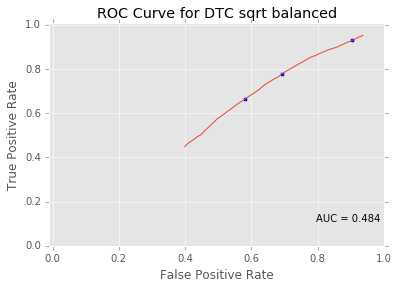

all   score: 0.652  baseline: 0.848   prec: 0.806   f1: 0.772  | test score 0.372  prec 0.817 f1 0.475  GP -186MM
2011  score: 0.740  baseline: 0.896   prec: 0.888   f1: 0.846  | test score 0.760  prec 0.869
2012  score: 0.648  baseline: 0.866   prec: 0.841   f1: 0.772  | test score 0.630  prec 0.842
2013  score: 0.654  baseline: 0.822   prec: 0.778   f1: 0.772  | test score 0.629  prec 0.788


In [86]:
eval_model_by_year(lambda: DTC(max_depth = 20, max_features = 'sqrt', class_weight = 'balanced', criterion = 'entropy'),
                  model_name='DTC sqrt balanced')

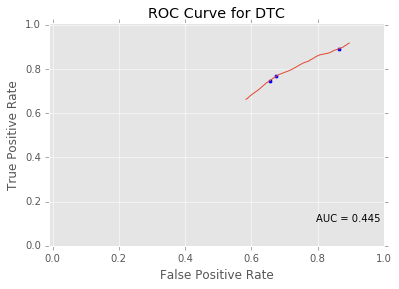

all   score: 0.671  baseline: 0.848   prec: 0.809   f1: 0.789  | test score 0.314  prec 0.804 f1 0.385  GP -381MM
2011  score: 0.775  baseline: 0.896   prec: 0.870   f1: 0.869  | test score 0.761  prec 0.841
2012  score: 0.690  baseline: 0.866   prec: 0.841   f1: 0.807  | test score 0.733  prec 0.838
2013  score: 0.657  baseline: 0.822   prec: 0.781   f1: 0.775  | test score 0.641  prec 0.789


In [87]:
eval_model_by_year(lambda: DTC(max_depth = 20, max_features = None, class_weight = 'balanced', criterion = 'entropy'),
                  model_name='DTC')

In [88]:
# This takes a very long time for practically no uplift
#eval_model_all_years(lambda: SVC(class_weight='balanced', probability=True))

In [89]:
# This takes a very long time for practically no uplift
#eval_model_all_years(lambda: SVC(class_weight='balanced', probability=True), prob_threshold=0.85)

#### Other Models without PCA

In [90]:
# TODO: Try again, this time fitting a regression against the payments received

In [91]:
# Curious -- what are the 95 CI for the baselines?
for yr in set(years.values):
    yr_n = (years == yr).sum()
    yr_def = (y[years == yr]).sum()
    yr_p = (y[years == yr]).mean()
    yr_se = (yr_p * (1.0-yr_p) / yr_n)
    print "y=%4d   n=%4d   d=%4d   p: %.3f | %.3f | %.3f" % (yr, yr_n, yr_def, yr_p - 1.96*yr_se, yr_p, yr_p + 1.96*yr_se)

y=2011   n=3561   d=3190   p: 0.896 | 0.896 | 0.896
y=2012   n=10764   d=9318   p: 0.866 | 0.866 | 0.866
y=2013   n=13857   d=11389   p: 0.822 | 0.822 | 0.822


In [92]:
# Default rate for small business is higher, right?
print y.mean()
print y[x_expanded.loan_purpose__small_business == 1].mean()

0.847952593854
0.761029411765


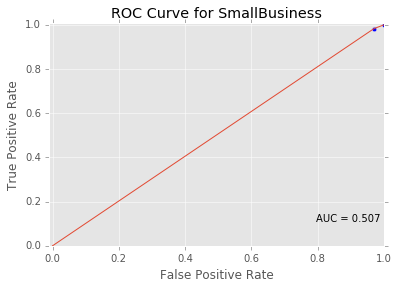

all   score: 0.838  baseline: 0.848   prec: 0.763   f1: 0.911  | test score 0.162  prec 0.761 f1 0.034  GP -869MM
2011  score: 0.872  baseline: 0.896   prec: 0.810   f1: 0.931  | test score 0.872  prec 0.797
2012  score: 0.853  baseline: 0.866   prec: 0.790   f1: 0.920  | test score 0.850  prec 0.794
2013  score: 0.817  baseline: 0.822   prec: 0.671   f1: 0.899  | test score 0.821  prec 0.662


In [93]:
eval_model_by_year(lambda: Log_Reg(class_weight='balanced'), ['loan_purpose__small_business'], model_name='SmallBusiness')

In [94]:
# LogReg is doing well.. what are the largest coefficients?
lr = Log_Reg(class_weight='balanced').fit(x_expanded[years.isin([2011,2012,2013])], y[years.isin([2011,2012,2013])])
lr_coeff = pd.DataFrame(lr.coef_.T, index=x_expanded.columns)
lr_coeff.columns = ['coeff']
lr_coeff['abs'] = lr_coeff.coeff.abs()

In [95]:
lr_coeff.sort_values('abs', ascending=False).coeff

loan_amount                                      2.705566
installment                                     -2.521193
employ_title__JPMorgan_Chase                     1.699582
employ_title__State_of_California                1.679309
employ_title__Department_of_Defense              1.528791
employ_title__US_Navy                            1.446454
home_owner__OTHER                                1.153812
employ_title__United_Parcel_Service             -0.937644
employ_title__United_States_Air_Force            0.833091
employ_title__Wells_Fargo                       -0.810605
home_owner__NONE                                 0.804666
employ_title__U.S._Army                          0.802576
employ_title__Administrative_Assistant           0.793232
employ_title__United_States_Postal_Service      -0.690232
address_state__AK                                0.661725
home_owner__RENT                                -0.613979
address_state__WY                                0.609044
employ_title__

In [96]:
lr_probs = lr.predict_proba(x_expanded)[:,0]

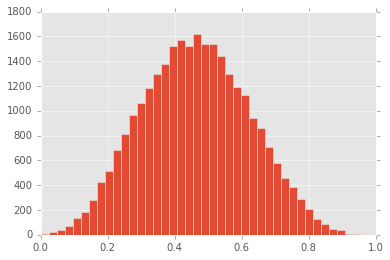

In [97]:
plt.hist(lr_probs ,bins=40)
plt.show()

In [98]:
1 - y.groupby([int(p*20)/20.0 for p in lr_probs]).mean()

0.00    0.000000
0.05    0.023077
0.10    0.027322
0.15    0.041096
0.20    0.046143
0.25    0.062437
0.30    0.078250
0.35    0.089011
0.40    0.117359
0.45    0.139627
0.50    0.169866
0.55    0.196835
0.60    0.250235
0.65    0.268524
0.70    0.319925
0.75    0.385965
0.80    0.386207
0.85    0.449541
0.90    0.571429
0.95    0.666667
Name: loan_status, dtype: float64

In [99]:
# probs = eval_model_with_threshold(lambda: Log_Reg())

In [100]:
# probs = eval_model_with_threshold(lambda: Log_Reg(class_weight='balanced'))

In [101]:
# VERY SLOW
#probs = eval_model_with_threshold(lambda: SVC(
#        random_state=1729,
#        probability=True))

#### Models with PCA

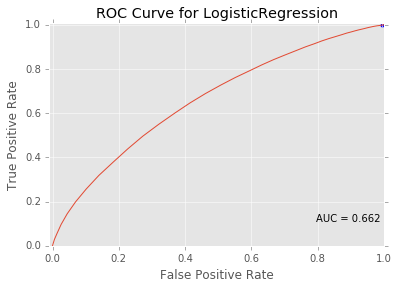

all   score: 0.848  baseline: 0.848   prec: 0.524   f1: 0.917  | test score 0.152  prec 0.540 f1 0.002  GP -911MM
2011  score: 0.894  baseline: 0.896   prec: nan   f1: 0.944  | test score 0.893  prec 0.556
2012  score: 0.866  baseline: 0.866   prec: nan   f1: 0.928  | test score 0.865  prec 0.739
2013  score: 0.821  baseline: 0.822   prec: 0.514   f1: 0.901  | test score 0.823  prec 0.541


In [102]:
eval_model_by_year(lambda: Log_Reg(), x = x_expanded_pca, x_test = x_test_expanded_pca)

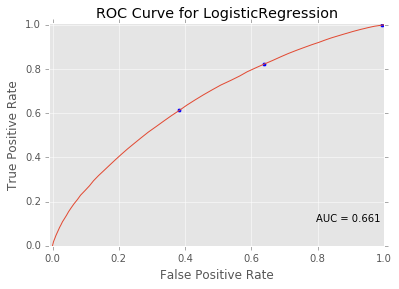

all   score: 0.619  baseline: 0.848   prec: 0.774   f1: 0.733  | test score 0.386  prec 0.778 f1 0.517  GP -15MM
2011  score: 0.632  baseline: 0.896   prec: 0.844   f1: 0.757  | test score 0.629  prec 0.843
2012  score: 0.607  baseline: 0.866   prec: 0.811   f1: 0.729  | test score 0.604  prec 0.817
2013  score: 0.634  baseline: 0.822   prec: 0.733   f1: 0.741  | test score 0.631  prec 0.739


In [103]:
eval_model_by_year(lambda: Log_Reg(class_weight='balanced'), x = x_expanded_pca, x_test = x_test_expanded_pca)

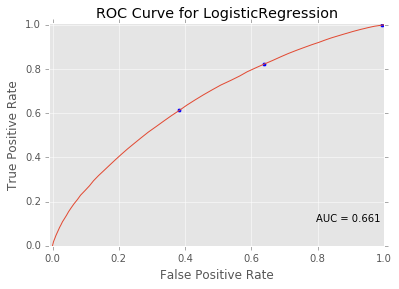

all   score: 0.619  baseline: 0.848   prec: 0.724   f1: 0.733  | test score 0.247  prec 0.733 f1 0.285  GP -473MM
2011  score: 0.632  baseline: 0.896   prec: 0.826   f1: 0.757  | test score 0.629  prec 0.818
2012  score: 0.607  baseline: 0.866   prec: 0.774   f1: 0.729  | test score 0.604  prec 0.791
2013  score: 0.634  baseline: 0.822   prec: 0.677   f1: 0.741  | test score 0.631  prec 0.692


In [104]:
eval_model_by_year(lambda: Log_Reg(class_weight='balanced'), prob_threshold=.6, 
                   x = x_expanded_pca, x_test = x_test_expanded_pca)

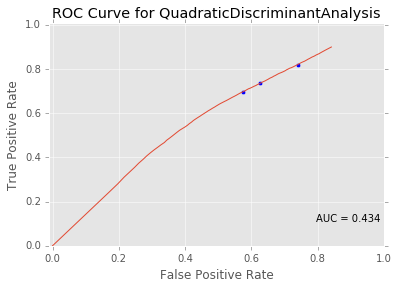

all   score: 0.660  baseline: 0.848   prec: 0.795   f1: 0.777  | test score 0.344  prec 0.799 f1 0.438  GP -249MM
2011  score: 0.597  baseline: 0.896   prec: 0.865   f1: 0.725  | test score 0.626  prec 0.869
2012  score: 0.655  baseline: 0.866   prec: 0.838   f1: 0.777  | test score 0.686  prec 0.838
2013  score: 0.659  baseline: 0.822   prec: 0.765   f1: 0.774  | test score 0.683  prec 0.762


In [105]:
eval_model_by_year(lambda: QDA(), x = x_expanded_pca, x_test = x_test_expanded_pca)

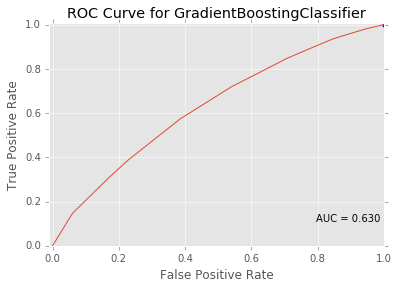

all   score: 0.848  baseline: 0.848   prec: nan   f1: 0.918  | test score 0.152  prec nan f1 0.000  GP -915MM
2011  score: 0.896  baseline: 0.896   prec: nan   f1: 0.945  | test score 0.893  prec nan
2012  score: 0.866  baseline: 0.866   prec: nan   f1: 0.928  | test score 0.865  prec nan
2013  score: 0.822  baseline: 0.822   prec: nan   f1: 0.902  | test score 0.824  prec nan


In [106]:
eval_model_by_year(lambda: GBC(n_estimators = 10, max_depth = 2, learning_rate = 0.1),
                  x = x_expanded_pca, x_test = x_test_expanded_pca)

## NLP Modeling

#### Top Terms in Each Class

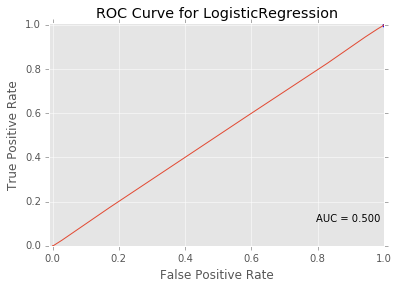

all   score: 0.860  baseline: 0.860   prec: nan   f1: 0.925  | test score 0.137  prec nan f1 0.000  GP -230MM
2011  score: 0.904  baseline: 0.904   prec: nan   f1: 0.949  | test score 0.893  prec nan
2012  score: 0.866  baseline: 0.866   prec: nan   f1: 0.928  | test score 0.867  prec nan
2013  score: 0.830  baseline: 0.830   prec: nan   f1: 0.907  | test score 0.837  prec nan


In [107]:
eval_model_by_year(lambda: Log_Reg(), x = count_cols_bool_train, x_test = count_cols_bool_test, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                  profit_data_test = x_nlp_test)

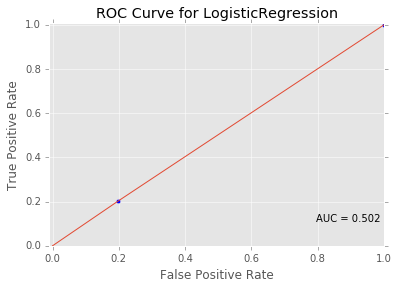

all   score: 0.296  baseline: 0.860   prec: 0.858   f1: 0.338  | test score 0.716  prec 0.862 f1 0.829  GP 198MM
2011  score: 0.628  baseline: 0.904   prec: 0.910   f1: 0.757  | test score 0.557  prec 0.875
2012  score: 0.294  baseline: 0.866   prec: 0.865   f1: 0.334  | test score 0.186  prec 0.868
2013  score: 0.511  baseline: 0.830   prec: 0.830   f1: 0.629  | test score 0.545  prec 0.838


In [108]:
eval_model_by_year(lambda: Log_Reg(C = 10 ** -6, class_weight = 'balanced'), 
                   x = count_cols_bool_train, x_test = count_cols_bool_test, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                  profit_data_test = x_nlp_test)

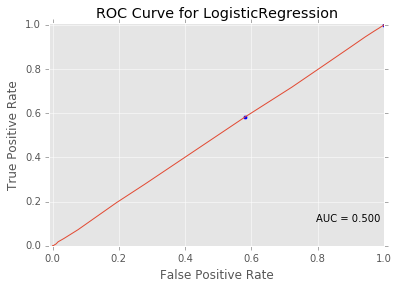

all   score: 0.565  baseline: 0.860   prec: 0.914   f1: 0.699  | test score 0.138  prec 0.826 f1 0.002  GP -230MM
2011  score: 0.478  baseline: 0.904   prec: 0.884   f1: 0.620  | test score 0.517  prec 0.921
2012  score: 0.578  baseline: 0.866   prec: 0.820   f1: 0.712  | test score 0.551  prec 0.914
2013  score: 0.527  baseline: 0.830   prec: 0.866   f1: 0.654  | test score 0.524  prec 0.759


In [109]:
eval_model_by_year(lambda: Log_Reg(class_weight = 'balanced'), prob_threshold = 0.6,
                   x = count_cols_bool_train, x_test = count_cols_bool_test, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                  profit_data_test = x_nlp_test)

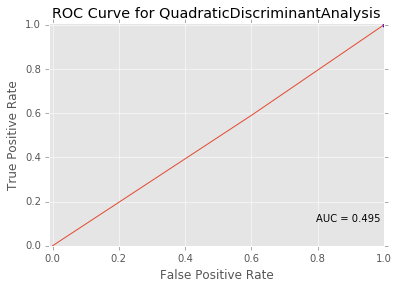

all   score: 0.860  baseline: 0.860   prec: nan   f1: 0.925  | test score 0.137  prec nan f1 0.000  GP -230MM
2011  score: 0.904  baseline: 0.904   prec: nan   f1: 0.949  | test score 0.893  prec nan
2012  score: 0.866  baseline: 0.866   prec: nan   f1: 0.928  | test score 0.867  prec nan
2013  score: 0.830  baseline: 0.830   prec: nan   f1: 0.907  | test score 0.837  prec nan


In [110]:
eval_model_by_year(lambda: QDA(reg_param = 1), x = count_cols_bool_train, x_test = count_cols_bool_test, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                  profit_data_test = x_nlp_test)

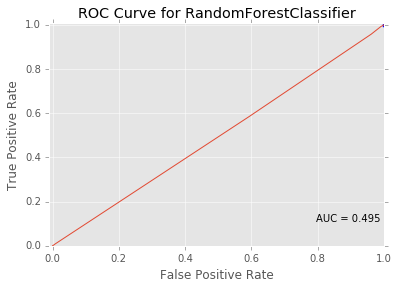

all   score: 0.860  baseline: 0.860   prec: nan   f1: 0.925  | test score 0.137  prec nan f1 0.000  GP -230MM
2011  score: 0.904  baseline: 0.904   prec: nan   f1: 0.949  | test score 0.893  prec nan
2012  score: 0.866  baseline: 0.866   prec: nan   f1: 0.928  | test score 0.867  prec nan
2013  score: 0.830  baseline: 0.830   prec: nan   f1: 0.907  | test score 0.837  prec nan


In [111]:
eval_model_by_year(lambda: RFC(random_state=1729, max_depth=5, n_estimators=300),
                    x = count_cols_bool_train, x_test = count_cols_bool_test, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                  profit_data_test = x_nlp_test)

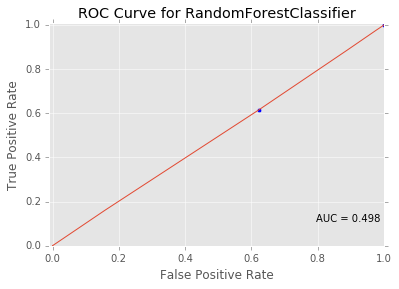

all   score: 0.582  baseline: 0.860   prec: 0.860   f1: 0.716  | test score 0.418  prec 0.865 f1 0.533  GP -24MM
2011  score: 0.555  baseline: 0.904   prec: 0.903   f1: 0.696  | test score 0.597  prec 0.885
2012  score: 0.632  baseline: 0.866   prec: 0.864   f1: 0.761  | test score 0.602  prec 0.872
2013  score: 0.534  baseline: 0.830   prec: 0.830   f1: 0.661  | test score 0.558  prec 0.838


In [112]:
eval_model_by_year(lambda: RFC(random_state=1729, max_depth=5, n_estimators=300, class_weight = 'balanced'),
                    x = count_cols_bool_train, x_test = count_cols_bool_test, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                  profit_data_test = x_nlp_test)

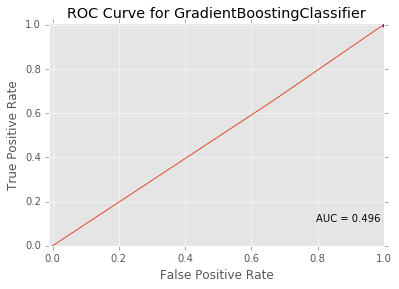

all   score: 0.860  baseline: 0.860   prec: nan   f1: 0.925  | test score 0.137  prec nan f1 0.000  GP -230MM
2011  score: 0.904  baseline: 0.904   prec: nan   f1: 0.949  | test score 0.893  prec nan
2012  score: 0.866  baseline: 0.866   prec: nan   f1: 0.928  | test score 0.867  prec nan
2013  score: 0.830  baseline: 0.830   prec: nan   f1: 0.907  | test score 0.837  prec nan


In [113]:
eval_model_by_year(lambda: GBC(n_estimators = 10, max_depth = 2, learning_rate = 0.1),
                    x = count_cols_bool_train, x_test = count_cols_bool_test, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                  profit_data_test = x_nlp_test)

#### Full Document-Term Matrix (Reduced with PCA)

C:\Users\agreene\AppData\Local\Continuum\Anaconda2\envs\amg1\lib\site-packages\pandas\core\internals.py:227: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 84854 but corresponding boolean dimension is 21485
  return self.values[slicer]
C:\Users\agreene\AppData\Local\Continuum\Anaconda2\envs\amg1\lib\site-packages\pandas\indexes\base.py:1275: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 84854 but corresponding boolean dimension is 21485
  result = getitem(key)


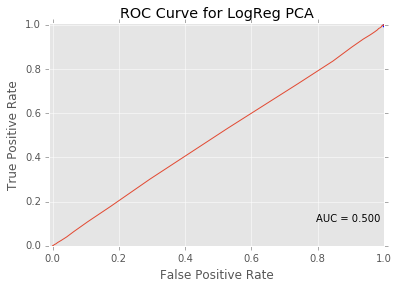

all   score: 0.860  baseline: 0.860   prec: 0.793   f1: 0.924  | test score 0.138  prec 0.857 f1 0.001  GP -236MM
2011  score: 0.900  baseline: 0.904   prec: 0.921   f1: 0.947  | test score 0.891  prec 0.875
2012  score: 0.864  baseline: 0.866   prec: 0.749   f1: 0.927  | test score 0.864  prec 0.824
2013  score: 0.830  baseline: 0.830   prec: 0.960   f1: 0.907  | test score 0.836  prec 0.750


In [114]:
eval_model_by_year(lambda: Log_Reg(), x = desc_matrix_pca, x_test = desc_matrix_test_pca, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                   model_name='LogReg PCA')

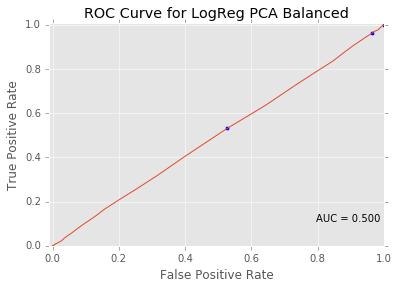

all   score: 0.524  baseline: 0.860   prec: 0.858   f1: 0.658  | test score 0.476  prec 0.861 f1 0.607  GP 20MM
2011  score: 0.590  baseline: 0.904   prec: 0.905   f1: 0.729  | test score 0.593  prec 0.910
2012  score: 0.522  baseline: 0.866   prec: 0.870   f1: 0.658  | test score 0.533  prec 0.864
2013  score: 0.530  baseline: 0.830   prec: 0.833   f1: 0.659  | test score 0.530  prec 0.840


In [115]:
eval_model_by_year(lambda: Log_Reg(class_weight = 'balanced'), x = desc_matrix_pca, x_test = desc_matrix_test_pca, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                   model_name='LogReg PCA Balanced')

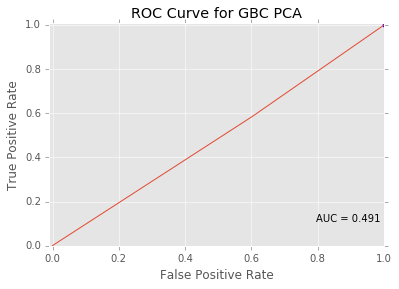

all   score: 0.860  baseline: 0.860   prec: nan   f1: 0.925  | test score 0.137  prec nan f1 0.000  GP -237MM
2011  score: 0.903  baseline: 0.904   prec: nan   f1: 0.949  | test score 0.893  prec nan
2012  score: 0.866  baseline: 0.866   prec: nan   f1: 0.928  | test score 0.867  prec nan
2013  score: 0.830  baseline: 0.830   prec: nan   f1: 0.907  | test score 0.837  prec nan


In [116]:
eval_model_by_year(lambda: GBC(n_estimators = 10, max_depth = 2, learning_rate = 0.1),
                   x = desc_matrix_pca, x_test = desc_matrix_test_pca,
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                   model_name='GBC PCA')

## Stacking

In [117]:
class Stacking(object):
    
    def __init__(self, unfitted_combiner, component_type = 'mixed'):
        self.combiner = unfitted_combiner
        self.model_stack = None   
        
        stack = []
        
        # logistic regression component models with various class weights
        if component_type == 'log_reg':
            for diff in np.arange(0, 5, 0.5):
                weight_dict = { 0 : 1, 1 : (1 + diff) }
                stack.append([Log_Reg(C = 1, class_weight = weight_dict), 'Log_Reg ' + str(1 + diff)])
                
        # default - mixed component models
        else:
            stack.append((Log_Reg(C = 10 ** -5), 'Log_Reg'))
            stack.append((Log_Reg(C = 10 ** -5, class_weight = 'balanced'), 'Log_Reg balanced'))
            stack.append((LDA(shrinkage = 1, solver = 'lsqr'), 'LDA'))
            stack.append((QDA(reg_param = 1), 'QDA'))
            stack.append((RFC(random_state=1729, n_estimators = 10, max_depth = 4), 'RF'))
            stack.append((RFC(random_state=1729, n_estimators = 300, max_depth = 5, class_weight = 'balanced'),
                        'RF balanced'))
            stack.append((GBC(n_estimators = 10, max_depth = 2, learning_rate = 0.1), 'Boost'))
            stack.append((DTC(max_depth = 10, max_features = 'log2', class_weight = 'balanced', criterion = 'gini'),
                        'Tree 1'))
            stack.append((DTC(max_depth = 20, max_features = 'sqrt', class_weight = 'balanced', criterion = 'entropy'),
                        'Tree 2'))
            stack.append((DTC(max_depth = 20, max_features = None, criterion = 'entropy'), 'Tree 3'))
            #stack.append(SVC(class_weight = 'balanced')) # slow
                         
        self.model_stack = pd.DataFrame(stack, columns = ['Model_Params', 'Model'])
        self.num_models = len(self.model_stack)
    
    def _predict_component_models(self, X):
        n = X.shape[0]
        y_hat_stack = np.zeros((n, self.num_models))
        for index in range(self.num_models):
            y_hat_stack[:, index] = self.model_stack.iloc[index, 0].predict(X)
        return y_hat_stack
        
    def fit(self, X, y):
        for index in range(self.num_models):
            self.model_stack.iloc[index, 0].fit(X, y)
        y_hat_stack = self._predict_component_models(X)
        self.combiner = self.combiner.fit(y_hat_stack, y)
        return self
        
    def score(self, X, y):
        y_hat_stack = self._predict_component_models(X)
        score = self.combiner.score(y_hat_stack, y)
        return score
              
    def predict(self, X):
        y_hat_stack = self._predict_component_models(X)
        y_hat = self.combiner.predict(y_hat_stack)
        return y_hat
    
    def predict_proba(self, X):
        y_hat_stack = self._predict_component_models(X)
        y_hat_proba = self.combiner.predict_proba(y_hat_stack)
        return y_hat_proba
    
    def confusion_matrix(self, y, y_hat):
        return confusion_matrix(y, y_hat)
     
    def f1_score(self, y, y_hat):
        return f1_score(y, y_hat, pos_label = 1)
    
    def get_features(self):
        long_name = str(type(self.combiner))
        short_name = re.sub('.*\.', '', long_name)
        short_name = re.sub('\'>', '', short_name)
        
        index = index = self.model_stack.iloc[:, 1]
        if short_name == 'LogisticRegression':
            return pd.DataFrame(self.combiner.coef_.T, index = index)
        else:
            return pd.DataFrame(self.combiner.feature_importances_.T, index = index)

In [118]:
def print_stacking_features(x_train, y_train, x_test, y_test, combiner, component_type = 'mixed'):
    model = Stacking(combiner, component_type)
    model.fit(x_train, y_train)
    
    features = model.get_features()
    features.columns = ['Importance']
    features['Abs'] = np.abs(features.Importance)
    features = features.sort_values('Abs', ascending = False).drop('Abs', axis = 1)
    display(features)

#### Regular Data

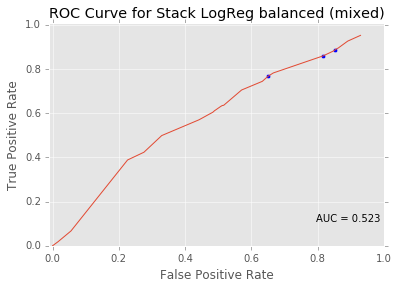

all   score: 0.691  baseline: 0.848   prec: 0.797   f1: 0.804  | test score 0.296  prec 0.788 f1 0.359  GP -380MM
2011  score: 0.806  baseline: 0.896   prec: 0.872   f1: 0.891  | test score 0.797  prec 0.870
2012  score: 0.731  baseline: 0.866   prec: 0.835   f1: 0.838  | test score 0.732  prec 0.820
2013  score: 0.681  baseline: 0.822   prec: 0.777   f1: 0.795  | test score 0.685  prec 0.757


In [119]:
combiner = Log_Reg(C = 1, class_weight = 'balanced', penalty = 'l2', solver = 'liblinear')
eval_model_by_year(lambda: Stacking(combiner), model_name = "Stack LogReg balanced (mixed)")

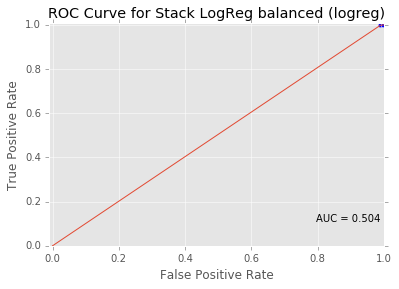

all   score: 0.848  baseline: 0.848   prec: 0.540   f1: 0.917  | test score 0.152  prec 0.540 f1 0.005  GP -901MM
2011  score: 0.895  baseline: 0.896   prec: 0.550   f1: 0.944  | test score 0.893  prec 0.600
2012  score: 0.866  baseline: 0.866   prec: 0.497   f1: 0.928  | test score 0.865  prec 0.667
2013  score: 0.821  baseline: 0.822   prec: 0.530   f1: 0.901  | test score 0.824  prec 0.521


In [120]:
combiner = Log_Reg(C = 1, class_weight = 'balanced', penalty = 'l2', solver = 'liblinear')
eval_model_by_year(lambda: Stacking(combiner, 'log_reg'), model_name = "Stack LogReg balanced (logreg)")

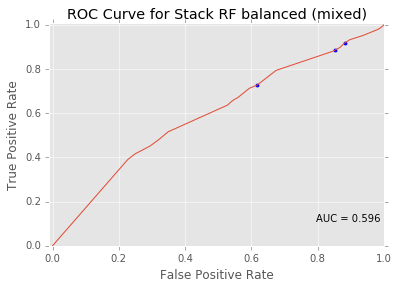

all   score: 0.666  baseline: 0.848   prec: 0.794   f1: 0.782  | test score 0.325  prec 0.799 f1 0.406  GP -308MM
2011  score: 0.818  baseline: 0.896   prec: 0.877   f1: 0.898  | test score 0.815  prec 0.886
2012  score: 0.705  baseline: 0.866   prec: 0.839   f1: 0.819  | test score 0.730  prec 0.857
2013  score: 0.679  baseline: 0.822   prec: 0.765   f1: 0.792  | test score 0.637  prec 0.777


In [121]:
combiner = RFC(random_state=1729, n_estimators = 10, max_depth = 4, max_features = 'sqrt', 
               criterion = 'gini', class_weight = 'balanced')
eval_model_by_year(lambda: Stacking(combiner), model_name = "Stack RF balanced (mixed)")

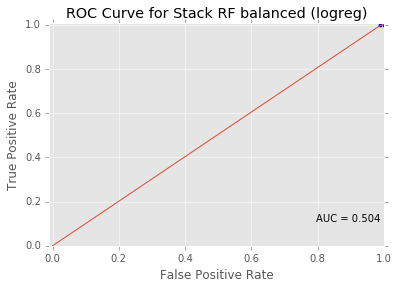

all   score: 0.848  baseline: 0.848   prec: 0.543   f1: 0.917  | test score 0.152  prec 0.540 f1 0.005  GP -901MM
2011  score: 0.586  baseline: 0.896   prec: 0.705   f1: 0.570  | test score 0.893  prec 0.600
2012  score: 0.578  baseline: 0.866   prec: 0.494   f1: 0.558  | test score 0.135  prec 0.865
2013  score: 0.820  baseline: 0.822   prec: 0.553   f1: 0.901  | test score 0.823  prec 0.533


In [122]:
combiner = RFC(random_state=1729, n_estimators = 10, max_depth = 4, max_features = 'sqrt', 
               criterion = 'gini', class_weight = 'balanced')
eval_model_by_year(lambda: Stacking(combiner, 'log_reg'), model_name = "Stack RF balanced (logreg)")

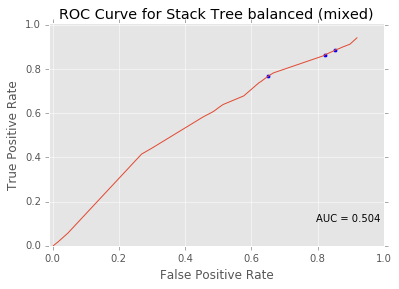

all   score: 0.694  baseline: 0.848   prec: 0.795   f1: 0.807  | test score 0.296  prec 0.788 f1 0.359  GP -380MM
2011  score: 0.808  baseline: 0.896   prec: 0.877   f1: 0.892  | test score 0.803  prec 0.868
2012  score: 0.734  baseline: 0.866   prec: 0.835   f1: 0.840  | test score 0.732  prec 0.820
2013  score: 0.690  baseline: 0.822   prec: 0.774   f1: 0.803  | test score 0.685  prec 0.758


In [123]:
combiner = DTC(max_depth = 10, max_features = 'log2', class_weight = 'balanced', 
                           criterion = 'gini')
eval_model_by_year(lambda: Stacking(combiner), model_name = "Stack Tree balanced (mixed)")

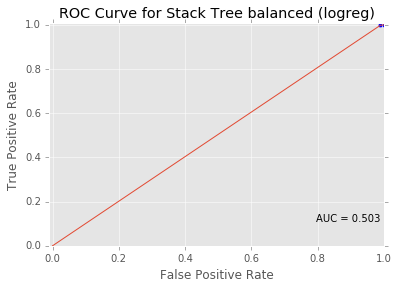

all   score: 0.848  baseline: 0.848   prec: 0.540   f1: 0.917  | test score 0.152  prec 0.540 f1 0.005  GP -901MM
2011  score: 0.895  baseline: 0.896   prec: 0.550   f1: 0.944  | test score 0.893  prec 0.600
2012  score: 0.866  baseline: 0.866   prec: 0.497   f1: 0.928  | test score 0.865  prec 0.667
2013  score: 0.821  baseline: 0.822   prec: 0.530   f1: 0.901  | test score 0.824  prec 0.520


In [124]:
combiner = DTC(max_depth = 10, max_features = 'log2', class_weight = 'balanced', 
                           criterion = 'gini')
eval_model_by_year(lambda: Stacking(combiner, 'log_reg'), model_name = "Stack Tree balanced (logreg)")

#### Stacking Feature Importances

In [125]:
combiner = Log_Reg(C = 1, class_weight = 'balanced', penalty = 'l2', solver = 'liblinear')
print_stacking_features(x_expanded, y, x_test_expanded, y_test, combiner, 'mixed')

,Importance
Model,
Tree 3,6.590679
Tree 2,2.594908
Log_Reg,-1.397559
RF,-1.397559
Boost,-1.397559
QDA,-1.197037
RF balanced,0.937416
Tree 1,0.643438
Log_Reg balanced,-0.399790


In [126]:
combiner = RFC(random_state=1729, n_estimators = 10, max_depth = 4, max_features = 'sqrt', 
               criterion = 'gini', class_weight = 'balanced')
print_stacking_features(x_expanded, y, x_test_expanded, y_test, combiner, 'mixed')

,Importance
Model,
Tree 3,0.662862
Tree 2,0.263022
RF balanced,0.025863
Log_Reg balanced,0.018869
LDA,0.015518
Tree 1,0.012842
QDA,0.001023
Log_Reg,0.000000
RF,0.000000


In [127]:
combiner = DTC(max_depth = 10, max_features = 'log2', class_weight = 'balanced', 
                           criterion = 'gini')
print_stacking_features(x_expanded, y, x_test_expanded, y_test, combiner, 'mixed')

,Importance
Model,
Tree 3,0.543211
Tree 2,0.339390
RF balanced,0.103649
Tree 1,0.009315
Log_Reg balanced,0.002946
LDA,0.001290
QDA,0.000199
Log_Reg,0.000000
RF,0.000000


## Visualizations

In [128]:
pd.DataFrame(model_performance).T

,auc,baseline,f1,prec,score,test_f1,test_prec,test_profit,test_score
Always 1,0.000000,0.847953,0.000000,0.847953,0.152047,0.917955,0.848351,1221.642931,0.848351
DTC,0.444557,0.847953,0.789154,0.808802,0.670996,0.384910,0.804275,-381.827226,0.314045
DTC log2 balanced,0.578260,0.847953,0.691262,0.813565,0.568199,0.469373,0.806245,-159.862205,0.365003
DTC sqrt balanced,0.483771,0.847953,0.771913,0.806301,0.651656,0.474506,0.817182,-186.325066,0.371815
GBC,0.630051,0.847953,0.917717,NaN,0.847953,0.000000,NaN,-915.941869,0.151649
GBC PCA,0.491381,0.860074,0.924770,NaN,0.860074,0.000000,NaN,-237.070559,0.137398
GradientBoostingClassifier,0.495911,0.860074,0.924770,NaN,0.860074,0.000000,NaN,-230.871859,0.137398
LogReg,0.674048,0.847953,0.917334,0.539907,0.847598,0.004647,0.540193,-901.854530,0.151943
LogReg PCA,0.500229,0.860074,0.924484,0.793333,0.859595,0.001294,0.857143,-236.575713,0.137864
LogReg PCA Balanced,0.500083,0.860074,0.657955,0.858047,0.524233,0.606677,0.861497,20.412340,0.476332


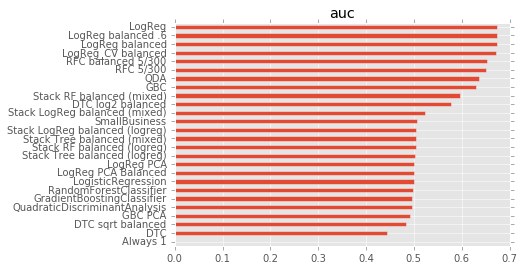

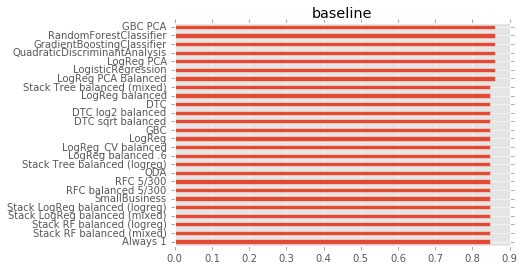

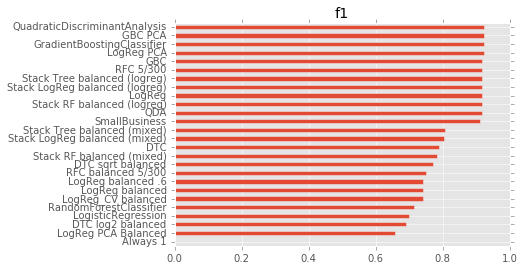

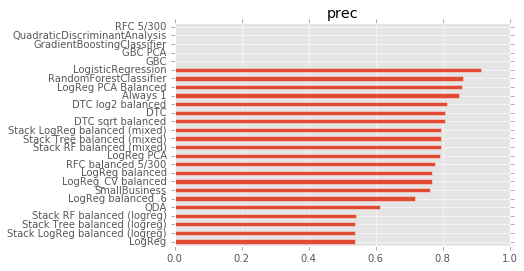

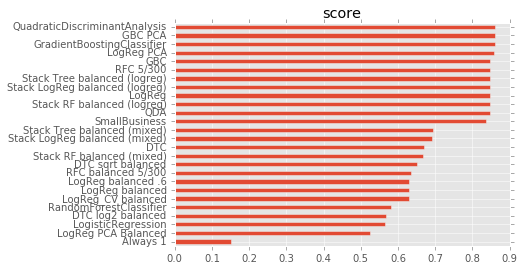

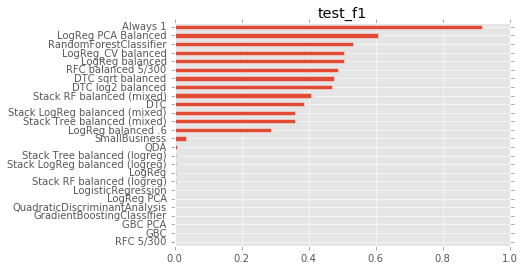

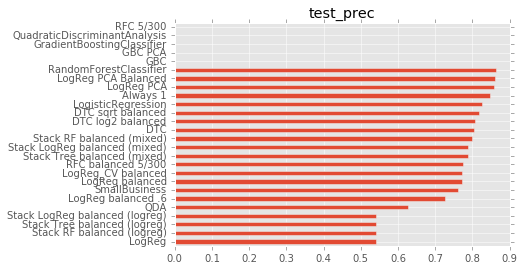

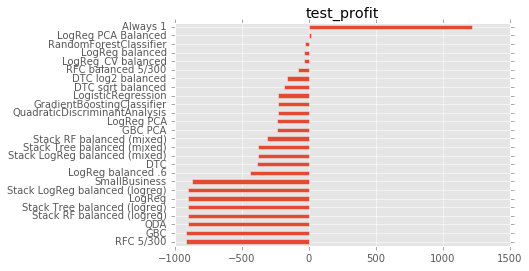

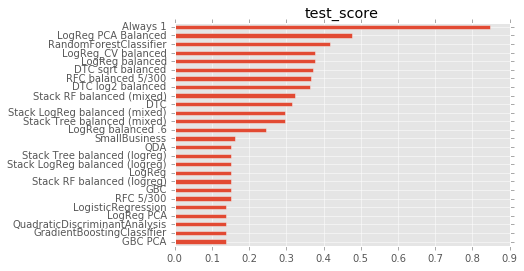

In [129]:
model_performance_df = pd.DataFrame(model_performance).T
for col in model_performance_df.columns:
    model_performance_df[col].sort_values().plot(kind='barh')
    plt.title(col)
    plt.show()